In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:
import numpy as np

def score_calculator(testY, pred, std, actual_threshold, pred_thresholds):
	actual_val = np.array(testY).flatten()
	pred_val = np.array(pred).flatten()
	std_val = np.array(std).flatten()

	actual_error = np.abs(actual_val - pred_val)
	pct_err_gt_thresh = actual_error > actual_threshold
	pct_err_gt_thresh = np.array(pct_err_gt_thresh)

	pct_err_gt_thresh = pct_err_gt_thresh[:, np.newaxis]
	std_val_reshaped = std_val[:, np.newaxis]
	pred_thresholds_reshaped = pred_thresholds[np.newaxis, :]

	std_gt_pred_thresh = std_val_reshaped > pred_thresholds_reshaped
	TP = np.sum(pct_err_gt_thresh & std_gt_pred_thresh, axis=0)
	FP = np.sum((~pct_err_gt_thresh) & std_gt_pred_thresh, axis=0)
	FN = np.sum(pct_err_gt_thresh & (~std_gt_pred_thresh), axis=0)
	TN = np.sum((~pct_err_gt_thresh) & (~std_gt_pred_thresh), axis=0)
	
	# Calculate rates with zero-division protection
	tpr = np.where((TP + FN) > 0, TP / (TP + FN), 0.0)
	fpr = np.where((FP + TN) > 0, FP / (FP + TN), 0.0)
	precision = np.where((TP + FP) > 0, TP / (TP + FP), 0.0)
	recall = np.where((TP + FN) > 0, TP / (TP + FN), 0.0)
	
	return tpr, fpr, precision, recall, TP, FP, FN

In [3]:
df = pd.read_csv("tables_for_analysis/NGBooster_result.csv")
df

,Unnamed: 0,actual_dele,pred_ngb,error_ngb,e,propa,prope,propsini,da,dsini,de
0,0,0.000067,-0.026765,0.004526,0.023071,2.737673,0.023138,0.101525,2.000000e-08,0.001200,0.005300
1,1,-0.006115,-0.004982,0.003477,0.180419,2.697389,0.174304,0.201982,2.900000e-07,0.000002,0.000015
2,2,0.027774,0.031920,0.001614,0.191661,2.677371,0.219435,0.190465,5.900000e-06,0.000054,0.000110
3,3,-0.041527,-0.038526,0.001392,0.175703,3.140491,0.134176,0.079778,1.600000e-05,0.000006,0.000013
4,4,-0.038788,-0.049146,0.002846,0.262128,2.224343,0.223340,0.101150,9.700000e-03,0.001800,0.005600
...,...,...,...,...,...,...,...,...,...,...,...
499525,499525,0.047851,0.036288,0.008167,0.094050,3.076732,0.141901,0.108836,9.900000e-04,0.002100,0.006200
499526,499526,-0.004041,-0.003147,0.007722,0.032581,2.649896,0.028540,0.068396,2.100000e-06,0.000089,0.000110
499527,499527,0.005529,0.008130,0.002135,0.081338,2.888156,0.086867,0.059644,3.200000e-06,0.000014,0.000007
499528,499528,-0.016498,-0.012869,0.006530,0.089252,2.541128,0.072754,0.077453,2.800000e-06,0.000560,0.006500


In [4]:
actual_threshold = 0.008
pred_thresholds = np.linspace(0, 0.05, 1000)
testY = df["actual_dele"]
pred = df["pred_ngb"]
error = df["error_ngb"]
de = df["de"]

In [16]:
frac = (testY - pred)
int_need = len(testY[np.abs(frac) > 0.002])
int_dont_need = len(testY[np.abs(frac) < 0.002])
print(int_need/len(testY))

0.4711168498388485


Text(0, 0.5, 'Percentage needed to be integrated')

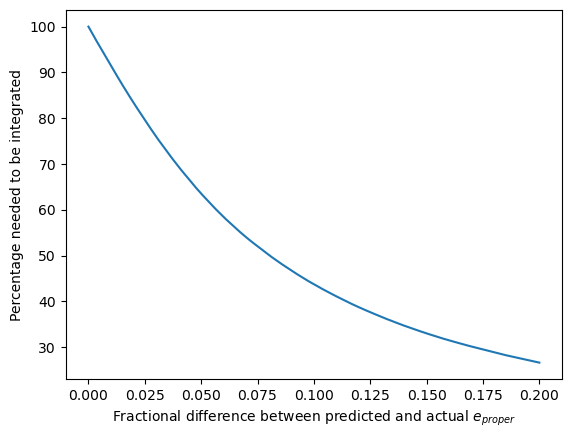

In [7]:
# Plot the threshold vs the systems we need to integrate
actual_thresholds = np.linspace(0, 0.2, 1000)
num_need_int = []
for i in range(len(actual_thresholds)):
	diff = (testY - pred)/testY
	int_need = len(testY[np.abs(diff) > actual_thresholds[i]])/len(testY) * 100
	num_need_int.append(int_need)

plt.plot(actual_thresholds, num_need_int)
plt.xlabel("Fractional difference between predicted and actual $e_{proper}$")
plt.ylabel("Percentage needed to be integrated")

In [47]:
tpr, fpr, precision, recall, TP, FP, FN = score_calculator(testY, pred, error, actual_threshold, pred_thresholds)
auc_scores = []

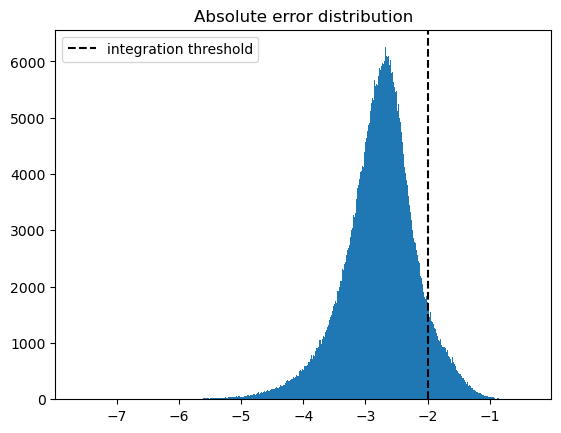

In [30]:
plt.hist(np.log10(np.abs(testY-pred)), bins=500)
plt.axvline(x=np.log10(actual_threshold), c='black', linestyle='--', label='integration threshold')
plt.title("Absolute error distribution")
plt.legend()
plt.show()

In [50]:
idx = np.argmin(np.abs(pred_thresholds - 0.006))
TP[idx]/len(testY), FP[idx]/len(testY), FN[idx]/len(testY)

(np.float64(0.07505054751466378),
 np.float64(0.014395531799891899),
 np.float64(0.16504113867035014))

Text(0.5, 1.0, 'Chi2 like error distribution')

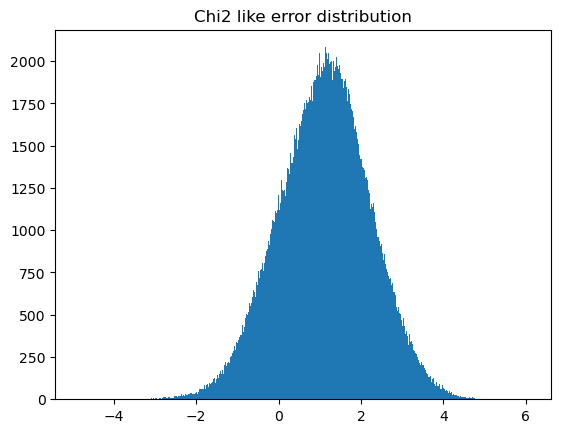

In [9]:
error_de = np.abs((testY - pred) / (de))
plt.hist(np.log10(error_de), bins = 1000)
plt.title("Chi2 like error distribution")

In [ ]:
actual_thresholds = np.linspace(0, 0.01, 1000)
for actual_thres in actual_thresholds:
	tpr, fpr, precision, recall, TP, FP, FN = score_calculator(testY, pred, error, actual_thres, pred_thresholds)
	fpr = np.array(fpr)
	tpr = np.array(tpr)
	sorted_indices = np.argsort(fpr)
	fpr = fpr[sorted_indices]
	tpr = tpr[sorted_indices]
	auc_score = auc(fpr, tpr)
	auc_scores.append(auc_score)

/tmp/ipykernel_159592/3397374077.py:24: RuntimeWarning: invalid value encountered in divide
  fpr = np.where((FP + TN) > 0, FP / (FP + TN), 0.0)


Text(0, 0.5, 'AUC score')

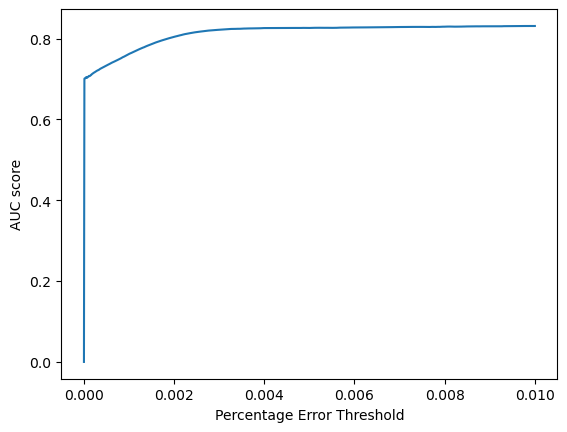

In [ ]:
plt.plot(actual_thresholds, auc_scores)
# plt.xlim(0.02, 0.1)
# plt.ylim(0.72, 0.74)
plt.xlabel("Absolute Error Threshold")
plt.ylabel("AUC score")

In [33]:
rms_nesvorny_vs_ml_xg=np.sqrt(np.median((testY-pred)**2))
rms_nesvorny_vs_ml_xg

np.float64(0.0018447141436089927)

In [32]:
fpr = np.array(fpr)
tpr = np.array(tpr)
sorted_indices = np.argsort(fpr)
fpr = fpr[sorted_indices]
tpr = tpr[sorted_indices]

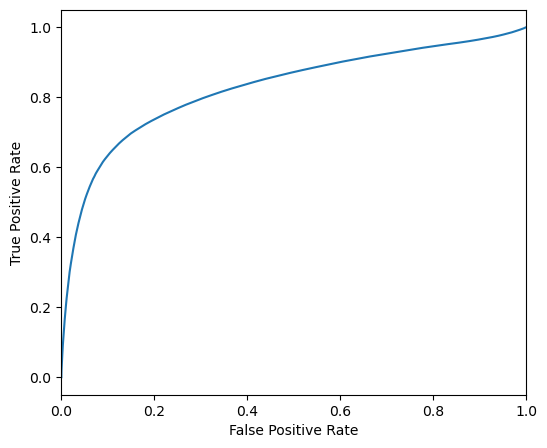

In [45]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

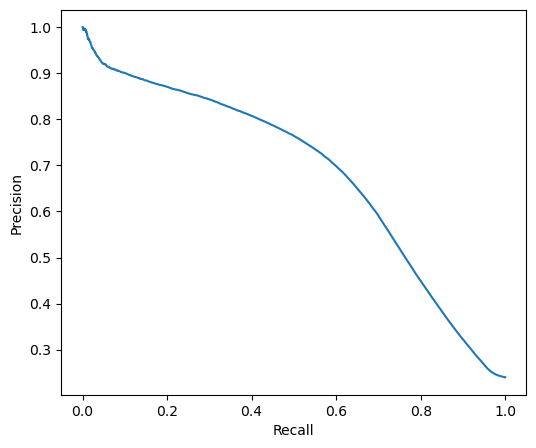

In [48]:
plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
# plt.xlim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [41]:
from sklearn.metrics import auc
auc_score = auc(fpr, tpr)
print(f"the AUC score is {auc_score}")

the AUC score is 0.8294560054115291


In [ ]:
df_nn = pd.read_csv("tables_for_analysis/Neural_Network_results.csv")
df_ngb = pd.read_csv("tables_for_analysis/NGBoost_results.csv")

In [7]:
frac_error = (testY - pred)/testY
frac_error = frac_error[np.isfinite(frac_error)]
q25, q75 = np.percentile(frac_error, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr / (len(frac_error) ** (1/3))
bin_width = bin_width if bin_width > 0 else 1e-6
num_bins = int(np.ceil((frac_error.max() - frac_error.min()) / bin_width))

len(frac_error[(frac_error < 0.05) & (frac_error > -0.05)])/len(frac_error)

0.36463548662840395

In [62]:
frac_error = frac_error[(frac_error < 2) & (frac_error > -2)]

In [63]:
frac_error

1         0.185345
2        -0.149261
3         0.072268
4        -0.267042
5         0.519890
            ...   
499525    0.241644
499526    0.221226
499527   -0.470433
499528    0.219925
499529    0.140397
Length: 483633, dtype: float64

(array([1.400e+01, 1.600e+01, 1.300e+01, 1.400e+01, 1.400e+01, 1.500e+01,
        9.000e+00, 1.100e+01, 7.000e+00, 1.700e+01, 2.100e+01, 9.000e+00,
        6.000e+00, 1.300e+01, 1.800e+01, 1.400e+01, 1.100e+01, 1.400e+01,
        1.700e+01, 1.600e+01, 1.100e+01, 1.400e+01, 1.600e+01, 1.300e+01,
        1.500e+01, 9.000e+00, 1.600e+01, 1.100e+01, 1.900e+01, 1.500e+01,
        1.400e+01, 1.700e+01, 1.900e+01, 1.500e+01, 1.300e+01, 1.400e+01,
        8.000e+00, 1.600e+01, 2.800e+01, 1.300e+01, 1.800e+01, 1.600e+01,
        2.100e+01, 1.800e+01, 8.000e+00, 1.700e+01, 1.400e+01, 1.700e+01,
        1.400e+01, 1.500e+01, 1.700e+01, 1.300e+01, 2.200e+01, 9.000e+00,
        2.400e+01, 1.800e+01, 1.400e+01, 1.700e+01, 1.300e+01, 1.800e+01,
        1.400e+01, 1.700e+01, 1.800e+01, 1.900e+01, 1.600e+01, 2.500e+01,
        1.400e+01, 1.400e+01, 1.500e+01, 2.600e+01, 2.400e+01, 2.700e+01,
        1.900e+01, 2.000e+01, 2.900e+01, 1.200e+01, 2.000e+01, 2.000e+01,
        1.500e+01, 2.000e+01, 1.800e+0

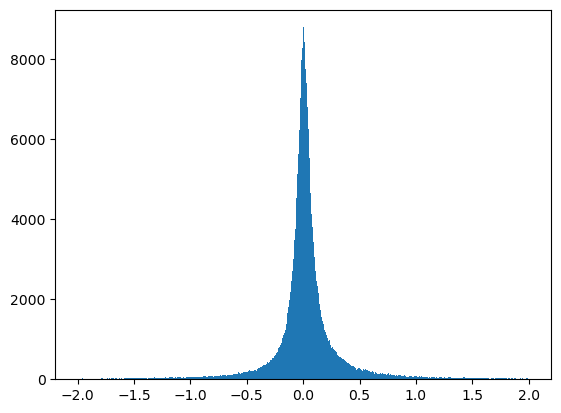

In [64]:
plt.hist(frac_error, bins = 1000)